**Use Pretrained models to predict on your own PET data**

Here you can use the following script to run inference (prediction) on your own pet data using the pretrained models described on the github page. 

The option are : 

- **Task511_PETAC_5foldEnsemble_nnunet.onnx** : This model uses 2 inputs, the PET image and the Attenuation Correction CT image pair. If you only want to predict on one PET Image then use the Task 521 model 

- **Task521_PET_5foldEnsemble_nnunet.onnx** : This model has 1 input. Only the PET image needs to be set to use this model. 

Adjust the inputs below by giving the path to the desired file you want to predict 

The models can now be found on the zenodo page for download : https://zenodo.org/record/7843469

For this script you only need the models that end in "onnx"

In [18]:
from batchgenerators.augmentations.utils import pad_nd_image
import gc
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import SimpleITK as sitk
import torchio as tio
import builtins
import os
import typing
from typing import List, Tuple
import numpy.typing as npt
from scipy.ndimage.filters import gaussian_filter
from __future__ import annotations

verbose = 0

In [19]:
# if you get an import error from the above - try running "pip install [nameofpackage]"
#Exampled : pip install batchgenerators


The images that you provide in the following filepaths can be either nifti images (nii.gz) or DICOM folders 

Also give the path to the models you downloaded above so that they can be found for the prediction


In [20]:
#PET Image only model (Task 521)

filepath_of_pet_image = '/Users/asantilli/Desktop/MSK_humanlevel/PT/Patient1/S0006_PET, Ga68_DOTATATE, Trans.nii.gz'
pet_model_path = '/Users/asantilli/Desktop/Task521_PET_5fold_nnunet.onnx'

# Path & name for predicted image to be saved - for both PET and PET+CT model
predicted_image_name = '/Users/asantilli/Desktop/pet_prediction.nii.gz'

#PET + CT model (Task 511)
#If you want to use the PET + CT model, set ADD_ACCT to True and provide a path to the ACCT image 
ADD_ACCT = False
filepath_of_ct_image = 'patient/S0002_CT-AC, Ga68 DOTATATE, Trans'
petct_model_path = 'onnx_pretrained_models/Task511_PETAC_5foldEnsemble_nnunet.onnx'

In [23]:
PATCH_SIZE_LIST = [224,96,112]
STEP_SIZE = 0.5
USE_GAUSSIAN = True
NUM_CLASSES = 2

def main():
    
    if filepath_of_pet_image.endswith('nii.gz'):
        pet_img = load_nifti(filepath_of_pet_image)
    else:
        pet_img = load_full_itk(filepath_of_pet_image)
    
    normalized_pet = preprocess_pet_images(pet_img)
    
    if ADD_ACCT:
        if filepath_of_ct_image.endswith('nii.gz'):
            ac_img = load_nifti(filepath_of_ct_image)
        else:
            ac_img = load_full_itk(filepath_of_ct_image)
              
        normalized_ac = preprocess_ct_images(ac_img)

        # stack the two images as 2 channels
        model_image = np.squeeze(np.asarray([normalized_pet, normalized_ac]))
        print(model_image.shape)
        model_name = petct_model_path
    else :
        model_image = normalized_pet
        model_name = pet_model_path


    print(model_image.shape)
    #Run Model
    predicted_seg = run_onnx_model(model_image, model_name)
    print(predicted_seg.shape)
    if len(predicted_seg.shape) != 4:
        predicted_seg = np.expand_dims(predicted_seg,0)
    final_seg = tio.ScalarImage(tensor=predicted_seg, affine=pet_img.affine)
    final_seg.save(predicted_image_name)
    return final_seg

def preprocess_ct_images(ac_img):
    # PREPROCESS AC/CT

    dim = ac_img.shape[3]
    transform = tio.CropOrPad((128, 128, dim))
    clamp = tio.Clamp(out_min=(50 - 160), out_max=(50 + 160))

    ac_crop = transform(ac_img)
    ac_pp_img = rescale(clamp(ac_crop))
    ac_model_image = np.transpose(ac_pp_img, axes=[0, 3, 2, 1])
    print("ACCT ", ac_model_image.shape)
    return ac_model_image

def preprocess_pet_images(pet_img):
    # PREPROCESS PET
    rescale = tio.RescaleIntensity(out_min_max=(0, 1))

    pet_pp_img = rescale(pet_img)

    # onnx model is flipped (c, z, x, y )
    pet_model_image = np.transpose(pet_pp_img, axes=[0, 3, 2, 1])

    print("Preprocessed Images")
    print("PET ", pet_model_image.shape)

    return pet_model_image

def load_full_itk(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    size = image.GetSize()
    print("Image size :" ,size)
    img = tio.ScalarImage.from_sitk(image)
    return img

def load_nifti(filename):
    img = tio.ScalarImage(filename)
    print("Image size: ", img.shape)
    return img


def run_onnx_model(image, model_name):

    patch_size_list = [int(x) for x in PATCH_SIZE_LIST]
    patch_size = tuple(patch_size_list)

    # compute steps for sliding window
    steps, num_tiles = compute_steps_for_sliding_window(
        patch_size, image.shape[1:], step_size=STEP_SIZE
    )
    if USE_GAUSSIAN:
        gaussian_importance_map, add_for_nb_of_preds = calculate_gaussian_filter(
            patch_size=patch_size, num_tiles=num_tiles
        )
        print("Gaussian map shape", gaussian_importance_map.shape)
    aggregated_results = np.zeros(
        [NUM_CLASSES] + list(image.shape[1:]), dtype=np.float32
    )
    aggregated_nb_of_predictions = np.zeros(
        [NUM_CLASSES] + list(image.shape[1:]), dtype=np.float32
    )
    # for sliding window inference the image must at least be as large as the patch size. It does not matter
    # whether the shape is divisible by 2**num_pool as long as the patch size is
    pad_image, slicer = pad_nd_image(
        image,
        patch_size,
        mode="constant",
        kwargs={"constant_values": 0},
        return_slicer=True,
    )

    batches = internal_3Dconv_tiled(
        pad_image,
        patch_size,
        steps,
        STEP_SIZE,
        NUM_CLASSES,
        do_mirroring=False,
        mirror_axes=(0, 1, 2),
    )

    # create ONNX session
    ort_session = ort.InferenceSession(model_name)

    for data, lb_x, ub_x, lb_y, ub_y, lb_z, ub_z in batches:
        batch = data[None, :, lb_x:ub_x, lb_y:ub_y, lb_z:ub_z]
        batch_blank = np.concatenate((batch, batch), axis=0).astype(np.float32)
        print(f"Batch shape: {batch_blank.shape}")
        inputs = ort_session.get_inputs()[0]
        input_name = inputs.name
        ort_inputs = {input_name: batch_blank}
        predicted_patch = ort_session.run(None, ort_inputs)[0][0]
        # apply gaussian
        predicted_patch[:] *= gaussian_importance_map
        aggregated_results[:, lb_x:ub_x, lb_y:ub_y, lb_z:ub_z] += predicted_patch
        aggregated_nb_of_predictions[
        :, lb_x:ub_x, lb_y:ub_y, lb_z:ub_z
        ] += add_for_nb_of_preds
    del predicted_patch
    print("aggregated_results", aggregated_results.shape)
    print("aggregated max", np.amax(aggregated_results))
    gc.collect()
    # we reverse the padding here (remember that we padded the input to be at least as large as the patch size
    slicer = tuple(
        [
            slice(0, aggregated_results.shape[i])
            for i in range(len(aggregated_results.shape) - (len(slicer) - 1))
        ]
        + slicer[1:]
    )
    aggregated_results = aggregated_results[slicer]
    aggregated_nb_of_predictions = aggregated_nb_of_predictions[slicer]

    # computing the class_probabilities by dividing the aggregated result with result_numsamples
    aggregated_results /= aggregated_nb_of_predictions
    del aggregated_nb_of_predictions
    predicted_segmentation = np.transpose(aggregated_results.argmax(0), axes=[2, 1, 0])
    return predicted_segmentation

def left_squeeze(array: npt.NDArray, *, n: builtins.int = 1) -> npt.NDArray:
    """remove up to 'n' empty dimensions from the left-most dims of an ndarray
    Examples:
        >>> left_squeeze(np.array([[0]]))
        array([0])
        >>> left_squeeze(np.zeros((1,1,2)), n=2)
        array([0., 0.])
        >>> left_squeeze(np.zeros((2,1,2)), n=2)
        array([[0., 0.],
               [0., 0.]])
    """
    axis = tuple(i for i, s in enumerate(array.shape[:n]) if s <= 1)
    return array.squeeze(axis=axis)


def to_cuda(data, non_blocking=True, gpu_id=0):
    if isinstance(data, list):
        data = [i.cuda(gpu_id, non_blocking=non_blocking) for i in data]
    else:
        data = data.cuda(gpu_id, non_blocking=non_blocking)
    return data


def internal_3Dconv_tiled(
    data: np.ndarray,
    patch_size: tuple,
    steps,
    step_size: float = 0.5,
    num_classes: int = 1,
    do_mirroring: bool = False,
    mirror_axes: Tuple[int, ...] = (0, 1, 2),
    # all_in_gpu: False, code can be extended to run on GPU as done in the code base
) -> typing.Generator[np.ndarray, int, int, int, int, int, int]:
    """Creates patches for prediction as done in the prediction code of the nnUNet"""
    # https://github.com/MIC-DKFZ/nnUNet/blob/5e5a151649af7386a2885fe2529fe6aa49bd2866/nnunet/network_architecture/neural_network.py

    # better safe than sorry
    assert len(data.shape) == 4, "x must be (c, x, y, z)"

    if verbose:
        print("step_size:", step_size)
        print("do mirror:", do_mirroring)

    assert patch_size is not None, "patch_size cannot be None for tiled prediction"

    if verbose:
        print("data shape:", data.shape)
        print("patch size:", patch_size)
        # print("steps (x, y, and z):", steps)

    for x in steps[0]:
        lb_x = x
        ub_x = x + patch_size[0]
        for y in steps[1]:
            lb_y = y
            ub_y = y + patch_size[1]
            for z in steps[2]:
                lb_z = z
                ub_z = z + patch_size[2]

                # send to ONNX model in main app
                yield data, lb_x, ub_x, lb_y, ub_y, lb_z, ub_z


def calculate_gaussian_filter(patch_size: tuple, num_tiles):
    # This is for saving a gaussian importance map for inference. It weights voxels higher that are closer to the
    # center. Prediction at the borders are often less accurate and are thus downweighted. Creating these Gaussians
    # can be expensive, so it makes sense to save and reuse them.
    _gaussian_3d = _patch_size_for_gaussian_3d = None
    # we only need to compute that once. It can take a while to compute this due to the large sigma in
    # gaussian_filter
    if num_tiles > 1:
        if _gaussian_3d is None or not all(
            [i == j for i, j in zip(patch_size, _patch_size_for_gaussian_3d)]
        ):
            if verbose:
                print("computing Gaussian")
            gaussian_importance_map = get_gaussian(patch_size, sigma_scale=1.0 / 8)

            _gaussian_3d = gaussian_importance_map
            _patch_size_for_gaussian_3d = patch_size
        else:
            if verbose:
                print("using precomputed Gaussian")
            gaussian_importance_map = _gaussian_3d
    else:
        gaussian_importance_map = None

    if num_tiles > 1:
        add_for_nb_of_preds = _gaussian_3d
    else:
        add_for_nb_of_preds = np.ones(patch_size, dtype=np.float32)

    return gaussian_importance_map, add_for_nb_of_preds


def compute_steps_for_sliding_window(
    patch_size: Tuple[int, ...], image_size: Tuple[int, ...], step_size: float
) -> List[List[int]]:
    # compute the steps for sliding window
    assert [
        i >= j for i, j in zip(image_size, patch_size)
    ], "image size must be as large or larger than patch_size"
    assert (
        0 < step_size <= 1
    ), "step_size must be larger than 0 and smaller or equal to 1"
    # our step width is patch_size*step_size at most, but can be narrower. For example if we have image size of
    # 110, patch size of 64 and step_size of 0.5, then we want to make 3 steps starting at coordinate 0, 23, 46
    target_step_sizes_in_voxels = [i * step_size for i in patch_size]

    num_steps = [
        int(np.ceil((i - k) / j)) + 1
        for i, j, k in zip(image_size, target_step_sizes_in_voxels, patch_size)
    ]
    steps = []
    for dim in range(len(patch_size)):
        # the highest step value for this dimension is
        max_step_value = image_size[dim] - patch_size[dim]
        if num_steps[dim] > 1:
            actual_step_size = max_step_value / (num_steps[dim] - 1)
        else:
            actual_step_size = (
                99999999999  # does not matter because there is only one step at 0
            )
        steps_here = [
            int(np.round(actual_step_size * i)) for i in range(num_steps[dim])
        ]
        steps.append(steps_here)

    num_tiles = len(steps[0]) * len(steps[1]) * len(steps[2])
    return steps, num_tiles


def get_gaussian(patch_size, sigma_scale=1.0 / 8) -> np.ndarray:
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode="constant", cval=0)
    gaussian_importance_map = (
        gaussian_importance_map / np.max(gaussian_importance_map) * 1
    )
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0]
    )

    return gaussian_importance_map


predicted_image = main()


Image size:  (1, 128, 128, 299)
Preprocessed Images
PET  (1, 299, 128, 128)
(1, 299, 128, 128)
computing Gaussian
Gaussian map shape (224, 96, 112)
step_size: 0.5
do mirror: False
data shape: (1, 299, 128, 128)
patch size: (224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
Batch shape: (2, 1, 224, 96, 112)
aggregated_results (2, 299, 128, 128)
aggregated max 21.193363
(128, 128, 299)


Prediction has  763  positive pixels in its volume


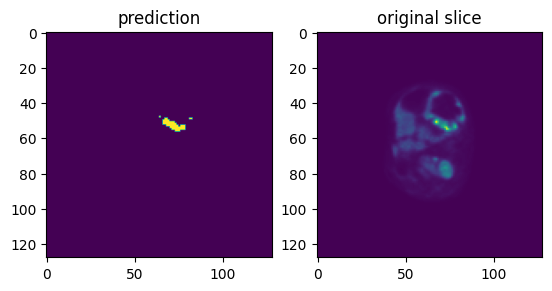

In [49]:
# VISUALIZE PREDICTION 

predicted_image = np.squeeze(predicted_image)
sum_pixel = np.sum(predicted_image)
print("Prediction has ", str(sum_pixel), " positive pixels in its volume")
dim = predicted_image.shape
slice_sums = [np.sum(predicted_image[:,:,i]) for i in range(dim[2])]
max_slice = np.argmax(slice_sums)
original_image = np.squeeze(tio.ScalarImage(filepath_of_pet_image))

fig, ax = plt.subplots(1,2)
ax[0].imshow(predicted_image[:,:,max_slice])
ax[0].set_title("prediction")
ax[1].imshow(original_image[:,:,max_slice])
ax[1].set_title("original slice")
plt.show()